In [1]:
%matplotlib inline
#%matplotlib notebook

import pyodbc
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D 


C:\ProgramData\Anaconda3\envs\ambulance\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\ProgramData\Anaconda3\envs\ambulance\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\envs\ambulance\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\envs\ambulance\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\envs\ambulance\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\envs\ambulance\lib\site-packages\

In [2]:
def get_incidents():
    cnxn = pyodbc.connect(
            r'Driver={SQL Server Native Client 11.0};Server=SERVERNAME;Database=DB;')
    cnxn.setencoding(encoding='utf-8', ctype=pyodbc.SQL_CHAR)
    cursor = cnxn.cursor()

    # define query to grab list of names
    query = '''
with some_cte(IncidentID, dispatch_code,NatureOfIncidentDescription,average_news_rate,average_conveyance_rate,admitted_rate)
AS
(select IncidentID, 
left(DispatchCodeAndSuffix,5) as dispatch_code,
NatureOfIncidentDescription,
cast(FirstNEWS1Total as decimal) as average_news_rate,
cast(NumberConveyances as decimal) as average_conveyance_rate,
case  when EDOutcome = 'Admitted' THEN 1 else 0 end as admitted_rate
from AmbulanceIncidentsLinked),

hospital_death_cte (IncidentID, died_in_hospital_within_2days)
as 
(select IncidentID,
case when LengthOfStay < 2 then 0 else CAST(DiedInHospital AS decimal) end as died_in_hospital_rate
from AmbulanceIncidentsLinked
)

select [Service and Government Standard] as MPDS_priority,
Description,
dispatch_code,
NatureOfIncidentDescription,
avg(died_in_hospital_within_2days) as died_in_hospital_rate,
avg(average_news_rate) as average_news_rate,
avg(average_conveyance_rate) as average_conveyance_rate,
avg(cast(admitted_rate as decimal)) as admitted_rate,
count(1) as frequency 
from some_cte
left join dwuserobj.Johng.DispatchCodeDescriptions on some_cte.dispatch_code = dwuserobj.Johng.DispatchCodeDescriptions.[Dispatch Code]
join hospital_death_cte on hospital_death_cte.IncidentID = some_cte.IncidentID
where [Service and Government Standard] is not null
group by [Service and Government Standard],dispatch_code,Description,NatureOfIncidentDescription
                '''


    dataframe = pd.read_sql(query, cnxn)
    cursor.close()
    del cursor
    cnxn.close()
    return dataframe
  

# Data Preprocessing

In [3]:
mpds_frame = get_incidents()
mpds_filtered = mpds_frame[mpds_frame['frequency']>5]

### Scale Features

In [10]:
standard_scaler = MinMaxScaler()
data = mpds_filtered[['died_in_hospital_rate', 'average_news_rate','average_conveyance_rate']]
data = data.fillna(value=0)
data['zero'] = 0
#print(data)
# normalized_df=(data-data['died_in_hospital_rate'].min())/(data['died_in_hospital_rate'].max()-data['died_in_hospital_rate'].min())
# print(scaled_shit)
mpds_filtered['scaled_news'] = (standard_scaler.fit_transform(data[['average_news_rate','zero']]))[:,0]
mpds_filtered['scaled_conveyance'] = (standard_scaler.fit_transform(data[['average_conveyance_rate','zero']]))[:,0]
mpds_filtered.fillna(value=0,inplace = True)

C:\ProgramData\Anaconda3\envs\ambulance\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\envs\ambulance\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\envs\ambulance\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

### drop features that I don't use

In [11]:
mpds_filtered.drop(['average_conveyance_rate','average_news_rate'],axis=1,inplace=True)


C:\ProgramData\Anaconda3\envs\ambulance\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Plot all data

<IPython.core.display.Javascript object>


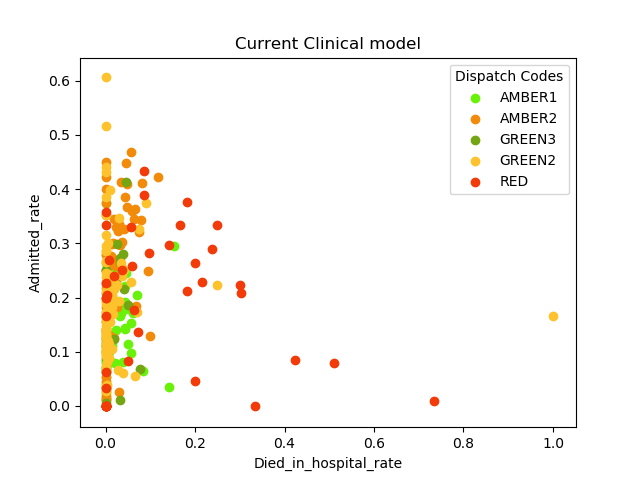

In [12]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111)

for mpds in mpds_filtered['MPDS_priority'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['MPDS_priority']==mpds]
    coordinates = current_plot_frame[['died_in_hospital_rate','admitted_rate',]]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c=color_dict[mpds])

ax.set_xlabel('Died_in_hospital_rate')
ax.set_ylabel('Admitted_rate')
ax.set_title('Current Clinical model')
ax.legend(['AMBER1', 'AMBER2','GREEN3','GREEN2','RED' ],title='Dispatch Codes')

<IPython.core.display.Javascript object>


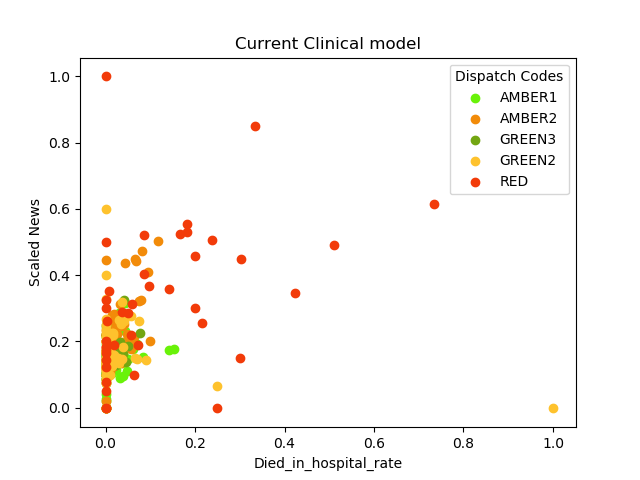

In [13]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111)

for mpds in mpds_filtered['MPDS_priority'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['MPDS_priority']==mpds]
    coordinates = current_plot_frame[['died_in_hospital_rate','scaled_news',]]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c=color_dict[mpds])

ax.set_xlabel('Died_in_hospital_rate')
ax.set_ylabel('Scaled News')
ax.set_title('Current Clinical model')
ax.legend(['AMBER1', 'AMBER2','GREEN3','GREEN2','RED' ],title='Dispatch Codes')

<IPython.core.display.Javascript object>


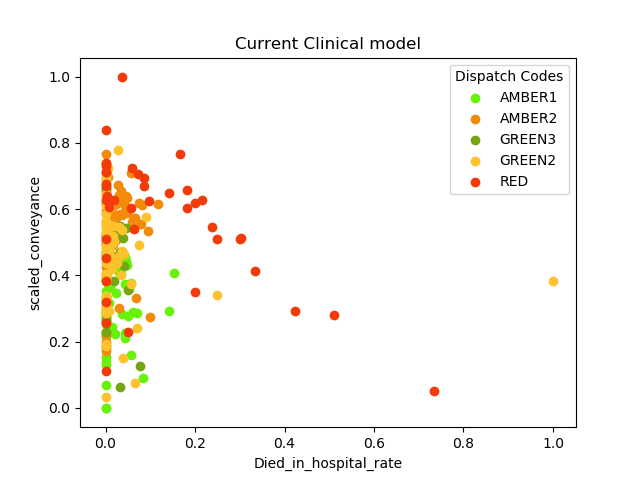

In [14]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111)

for mpds in mpds_filtered['MPDS_priority'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['MPDS_priority']==mpds]
    coordinates = current_plot_frame[['died_in_hospital_rate','scaled_conveyance',]]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c=color_dict[mpds])

ax.set_xlabel('Died_in_hospital_rate')
ax.set_ylabel('scaled_conveyance')
ax.set_title('Current Clinical model')
ax.legend(['AMBER1', 'AMBER2','GREEN3','GREEN2','RED' ],title='Dispatch Codes')

<IPython.core.display.Javascript object>


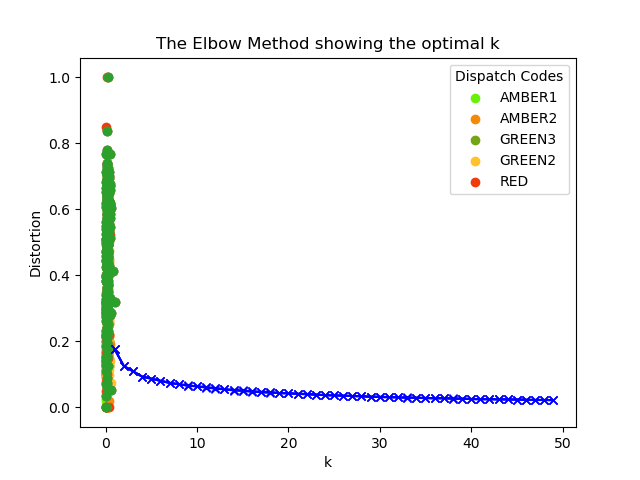

In [47]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111)

for mpds in mpds_filtered['MPDS_priority'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['MPDS_priority']==mpds]
    coordinates = current_plot_frame[['admitted_rate','scaled_news']]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c=color_dict[mpds])

ax.set_xlabel('admitted_rate')
ax.set_ylabel('scaled_news_rate')
ax.set_title('Current Clinical model')
ax.legend(['AMBER1', 'AMBER2','GREEN3','GREEN2','RED' ],title='Dispatch Codes')

<IPython.core.display.Javascript object>


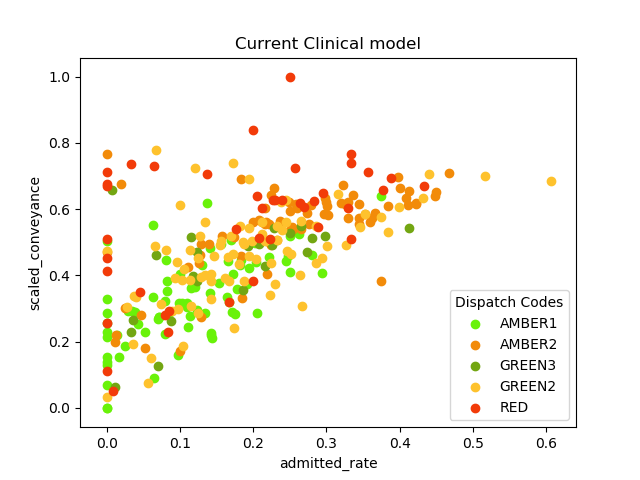

In [15]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111)

for mpds in mpds_filtered['MPDS_priority'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['MPDS_priority']==mpds]
    coordinates = current_plot_frame[['admitted_rate','scaled_conveyance']]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c=color_dict[mpds])

ax.set_xlabel('admitted_rate')
ax.set_ylabel('scaled_conveyance')
ax.set_title('Current Clinical model')
ax.legend(['AMBER1', 'AMBER2','GREEN3','GREEN2','RED' ],title='Dispatch Codes')

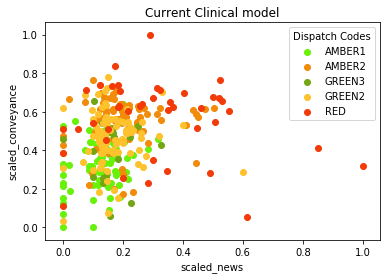

In [76]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111)

for mpds in mpds_filtered['MPDS_priority'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['MPDS_priority']==mpds]
    coordinates = current_plot_frame[['scaled_news','scaled_conveyance']]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c=color_dict[mpds])

ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('Current Clinical model')
ax.legend(['AMBER1', 'AMBER2','GREEN3','GREEN2','RED' ],title='Dispatch Codes')

# Clustering

## Kmeans

### Elbow

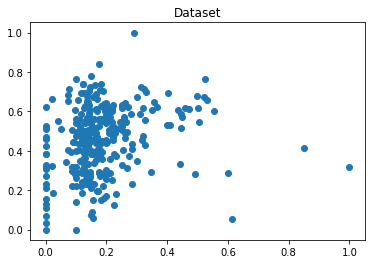

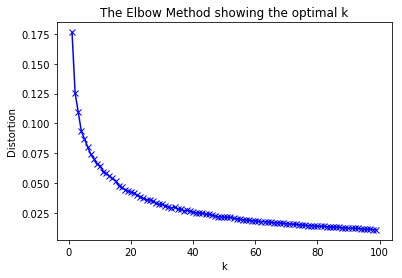

In [72]:
# clustering dataset
# determine k using elbow method

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
X = mpds_filtered[['scaled_news','scaled_conveyance']].values
x1 = X[:,0]
x2 = X[:,1]

plt.plot()
plt.title('Dataset')
plt.scatter(x1, x2)
plt.show()

# create new plot and data
plt.plot()
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,100)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


The elbow is a method of identifying the optimal number of clusters for k means, for our data it suggests 8 as the optimum number of clusters.

### Clustering Code

14


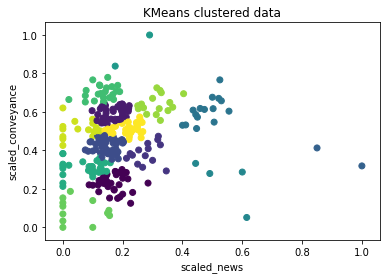

In [73]:
from sklearn.cluster import KMeans
fig = plt.figure()
clust = KMeans(n_clusters = 14, n_init=100, max_iter=500)
clust.fit(X)
labels = clust.labels_
mpds_filtered = mpds_filtered.assign(cluster_number_kmeans = labels)
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1],
               c=labels.astype(np.float))
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('KMeans clustered data')
mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")

Now that we have our clusters we can start color coding them according to their majority class and finding mismatches.

In [79]:
mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")
for cluster in mpds_filtered.cluster_number_kmeans.unique():
        current_frame = mpds_filtered[mpds_filtered['cluster_number_kmeans']==cluster]
        #pandas sorts by highest frequency first so we can take the first index to get the majority class
        mpds_filtered.loc[mpds_filtered.cluster_number_kmeans==cluster, 'majority_class'] =current_frame['MPDS_priority'].value_counts().index[0]

Now the classes are newly classified using the algorithm let's highlight examples that are not in their majority classes but first let's look at the new clusters

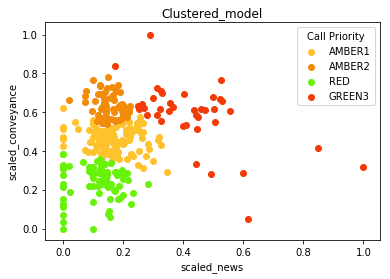

In [80]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111)

for mpds in mpds_filtered['majority_class'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['majority_class']==mpds]
    coordinates = current_plot_frame[['scaled_news','scaled_conveyance',]]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c=color_dict[mpds])

ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('Clustered_model')
ax.legend(['AMBER1', 'AMBER2','RED', 'GREEN3','GREEN3'],title='Call Priority')

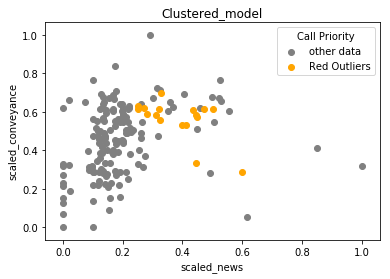

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111)


current_plot_frame = mpds_filtered[mpds_filtered['MPDS_priority']==mpds_filtered['majority_class']]
coordinates = current_plot_frame[['scaled_news','scaled_conveyance',]]
ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c='gray')

current_plot_frame = mpds_filtered[(mpds_filtered['MPDS_priority']!='RED') & (mpds_filtered['majority_class']=="RED")]
coordinates = current_plot_frame[['scaled_news','scaled_conveyance',]]
ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c='orange')


# current_plot_frame = mpds_filtered[(mpds_filtered['MPDS_priority']=='RED') & (mpds_filtered['majority_class']!="RED")]
# coordinates = current_plot_frame[['scaled_news','scaled_conveyance',]]
# ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c='red')



ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('Clustered_model')
ax.legend(['other data','Red Outliers','Amber Outliers'],title='Call Priority')

In [90]:
current_plot_frame = mpds_filtered[(mpds_filtered['MPDS_priority']!='RED') & (mpds_filtered['majority_class']=="RED")]

In [94]:
current_plot_frame = mpds_filtered[(mpds_filtered['MPDS_priority']=='RED') & (mpds_filtered['majority_class']!="RED")]


In [95]:
current_plot_frame

MPDS_priority                            Description dispatch_code  \
27            RED           Underwater (DOMESTIC rescue)         14E02   
67            RED                               Override         31E00   
77            RED                            Suffocation         09E05   
80            RED              3rd TRIMESTER haemorrhage         24D04   
108           RED  Baby born (complications with mother)         24D07   
115           RED                            Unconscious         30D02   
138           RED                            Unconscious         07D03   
141           RED                            Unconscious         17D03   
148           RED                            Unconscious         03D02   
166           RED                                 Arrest         03D01   
201           RED                                 Arrest         29D06   
207           RED                            Unconscious         08D02   
214           RED                                 Arrest         08D01   
244           RED               LIFE STATUS QUESTIONABLE         32D01   
249           RED                          Strangulation         09E04   
261           RED                                Hanging         09E03   
271           RED                HIGH RISK complications         24D05   
272           RED                       Head visible/out         24D02   
288           RED                               Override         23D00   

            NatureOfIncidentDescription  died_in_hospital_rate  admitted_rate  \
27          DROWNING(NEAR)/DIVING/SCUBA               0.000000       0.200000   
67           UNCONSCIOUS/FAINTING(NEAR)               0.000000       0.000000   
77     CARDIAC/RESPIRATORY ARREST/DEATH               0.000000       0.000000   
80     PREGNANCY/CHILDBIRTH/MISCARRIAGE               0.000000       0.033526   
108    PREGNANCY/CHILDBIRTH/MISCARRIAGE               0.000000       0.000000   
115        TRAUMATIC INJURIES, SPECIFIC               0.017857       0.239061   
138             BURNS(SCALDS)/EXPLOSION               0.000000       0.333333   
141                               FALLS               0.057781       0.329699   
148                ANIMAL BITES/ATTACKS               0.000000       0.227272   
166                ANIMAL BITES/ATTACKS               0.000000       0.000000   
201    TRAFFIC/TRANSPORTATION ACCIDENTS               0.071428       0.136363   
207  CARBON MONOXIDE/INHALATION/HAZCHEM               0.062500       0.176470   
214  CARBON MONOXIDE/INHALATION/HAZCHEM               0.200000       0.045454   
244  UNKNOWN PROBLEM - COLLAPSE-3RD PTY               0.050000       0.083333   
249    CARDIAC/RESPIRATORY ARREST/DEATH               0.300000       0.222222   
261    CARDIAC/RESPIRATORY ARREST/DEATH               0.424242       0.084337   
271    PREGNANCY/CHILDBIRTH/MISCARRIAGE               0.000000       0.063607   
272    PREGNANCY/CHILDBIRTH/MISCARRIAGE               0.000000       0.000000   
288      OVERDOSE/POISONING (INGESTION)               0.250000       0.333333   

     frequency  scaled_news  scaled_conveyance  cluster_number_kmeans  \
27          10     0.000000           0.383334                      8   
67           9     0.200000           0.255555                      0   
77           7     0.000000           0.109524                     10   
80         865     0.124031           0.736532                      9   
108        112     0.077778           0.711905                      9   
115       1577     0.188704           0.628113                      1   
138         27     0.183333           0.738271                      9   
141       7889     0.218762           0.603499                      1   
148         22     0.183333           0.627272                      1   
166          6     0.050000           0.511111                     12   
201         88     0.190000           0.705682                      9   
207         34     0.10000

In [82]:
mpds_filtered['majority_class'].value_counts(normalize = True)


AMBER2    0.394040
GREEN3    0.254967
AMBER1    0.218543
RED       0.132450
Name: majority_class, dtype: float64

In [83]:
mpds_filtered['MPDS_priority'].value_counts(normalize = True)

AMBER2    0.281457
GREEN3    0.251656
AMBER1    0.248344
RED       0.139073
GREEN2    0.079470
Name: MPDS_priority, dtype: float64

### Plot all data 3d

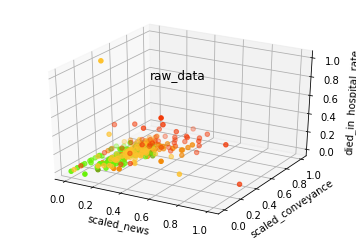

In [63]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for mpds in mpds_filtered['MPDS_priority'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['MPDS_priority']==mpds]
    coordinates = current_plot_frame[['scaled_news','scaled_conveyance','died_in_hospital_rate']]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],coordinates.iloc[:,2],c=color_dict[mpds])
    ax.set_xlabel('scaled_news')
    ax.set_ylabel('scaled_conveyance')
    ax.set_zlabel('died_in_hospital_rate')
    ax.set_title('raw_data')
    
mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")
for cluster in mpds_filtered.cluster_number_kmeans.unique():
        current_frame = mpds_filtered[mpds_filtered['cluster_number_kmeans']==cluster]
        #pandas sorts by highest frequency first so we can take the first index to get the majority class
        mpds_filtered.loc[mpds_filtered.cluster_number_kmeans==cluster, 'majority_class'] =current_frame['MPDS_priority'].value_counts().index[0]


### Elbow 3d

In [37]:
# clustering dataset
# determine k using elbow method

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
X = mpds_filtered[['scaled_news','scaled_conveyance','died_in_hospital_rate']].values
x1 = X[:,0]
x2 = X[:,1]
x3 = X[:,2]


# plt.plot()
plt.title('Dataset')
plt.scatter(x1, x2, x3)
plt.show()

# create new plot and data
# plt.plot()
X = np.array(list(zip(x1, x2, x3))).reshape(len(x1), 3)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


### Kmeans

40


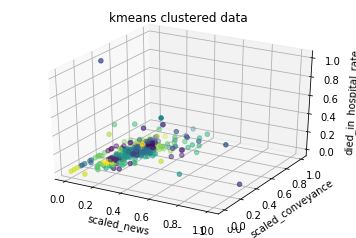

In [64]:
from sklearn.cluster import KMeans
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = mpds_filtered[['scaled_news','scaled_conveyance','died_in_hospital_rate']].values
clust = KMeans(n_clusters = 40, n_init=100, max_iter=500)
clust.fit(X)
labels = clust.labels_
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2],
               c=labels.astype(np.float))
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_zlabel('died_in_hospital_rate')
ax.set_title('kmeans clustered data')
mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")

### grouped kmeans

In [65]:
mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")
for cluster in mpds_filtered.cluster_number_kmeans.unique():
        current_frame = mpds_filtered[mpds_filtered['cluster_number_kmeans']==cluster]
        #pandas sorts by highest frequency first so we can take the first index to get the majority class
        mpds_filtered.loc[mpds_filtered.cluster_number_kmeans==cluster, 'majority_class'] =current_frame['MPDS_priority'].value_counts().index[0]

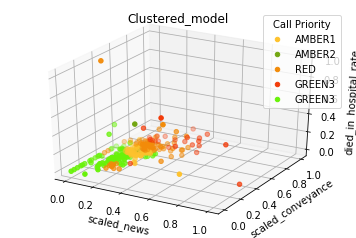

In [66]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

for mpds in mpds_filtered['majority_class'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['majority_class']==mpds]
    coordinates = current_plot_frame[['scaled_news','scaled_conveyance','died_in_hospital_rate']]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],coordinates.iloc[:,2],c=color_dict[mpds])

ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_zlabel('died_in_hospital_rate')
ax.set_title('Clustered_model')
ax.legend(['AMBER1', 'AMBER2','RED', 'GREEN3','GREEN3'],title='Call Priority')

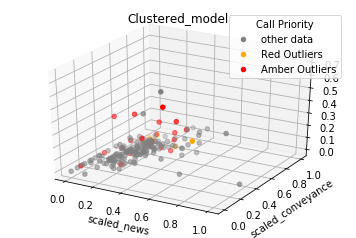

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')


current_plot_frame = mpds_filtered[mpds_filtered['MPDS_priority']==mpds_filtered['majority_class']]
coordinates = current_plot_frame[['scaled_news','scaled_conveyance','died_in_hospital_rate']]
ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],coordinates.iloc[:,2],c='gray')

current_plot_frame = mpds_filtered[(mpds_filtered['MPDS_priority']!='RED') & (mpds_filtered['majority_class']=="RED")]
coordinates = current_plot_frame[['scaled_news','scaled_conveyance','died_in_hospital_rate']]
ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],coordinates.iloc[:,2],c='orange')


current_plot_frame = mpds_filtered[(mpds_filtered['MPDS_priority']=='RED') & (mpds_filtered['majority_class']!="RED")]
coordinates = current_plot_frame[['scaled_news','scaled_conveyance','died_in_hospital_rate']]
ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],coordinates.iloc[:,2],c='red')


ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('Clustered_model')
ax.legend(['other data','Red Outliers','Amber Outliers'],title='Call Priority')

# 4d

## elbow 4d

In [27]:
# clustering dataset
# determine k using elbow method

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
X = mpds_filtered[['scaled_news','scaled_conveyance','died_in_hospital_rate','admitted_rate']].values
x1 = X[:,0]
x2 = X[:,1]
x3 = X[:,2]
x4 = X[:,3]



plt.plot()
plt.title('Dataset')
plt.scatter(x1, x2, x3)
plt.show()

# create new plot and data
plt.plot()
X = np.array(list(zip(x1, x2, x3,x4))).reshape(len(x1), 4)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,100)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


TypeError: plot() missing 2 required positional arguments: 'xs' and 'ys'

In [ ]:
from sklearn.cluster import KMeans
X = mpds_filtered[['scaled_news','scaled_conveyance','died_in_hospital_rate','admitted_rate']].values
clust = KMeans(n_clusters = 100, n_init=100, max_iter=500)
clust.fit(X)
labels = clust.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")

In [ ]:
for cluster in mpds_filtered.cluster_number_kmeans.unique():
        current_frame = mpds_filtered[mpds_filtered['cluster_number_kmeans']==cluster]
        #pandas sorts by highest frequency first so we can take the first index to get the majority class
        mpds_filtered.loc[mpds_filtered.cluster_number_kmeans==cluster, 'majority_class'] =current_frame['MPDS_priority'].value_counts().index[0]

In [ ]:
mpds_filtered[((mpds_filtered.MPDS_priority=="RED") & (mpds_filtered.majority_class!="RED"))]

## DBSCAN

### DBSCAN 2d

In [ ]:
from sklearn.cluster import DBSCAN
fig = plt.figure()
X = mpds_filtered[['scaled_news','scaled_conveyance']].values
clustering = DBSCAN(eps =0.025).fit(X)
mpds_filtered['cluster_number_dbscan'] = clustering.labels_
ax = fig.add_subplot(111)
labels = clustering.labels_
ax.scatter(X[:, 0], X[:, 1],
               c=labels.astype(np.float))
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('meanshift clustered data')

In [ ]:
mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")
for cluster in mpds_filtered.cluster_number_dbscan.unique():
        current_frame = mpds_filtered[mpds_filtered['cluster_number_dbscan']==cluster]
        #pandas sorts by highest frequency first so we can take the first index to get the majority class
        mpds_filtered.loc[mpds_filtered.cluster_number_dbscan==cluster, 'majority_class'] =current_frame['MPDS_priority'].value_counts().index[0]

In [ ]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111)

for mpds in mpds_filtered['majority_class'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['majority_class']==mpds]
    coordinates = current_plot_frame[['scaled_news','scaled_conveyance',]]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c=color_dict[mpds])

ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('Clustered_model')

### DBSCAN 3D

## Mean Shift Clustering

### Meanshift 2d

In [ ]:
from sklearn.cluster import MeanShift
fig = plt.figure()
X = mpds_filtered[['scaled_news','scaled_conveyance']].values
clustering = MeanShift().fit(X)
mpds_filtered['cluster_number_mean_shift'] = clustering.labels_
ax = fig.add_subplot(111)
labels = clustering.labels_
ax.scatter(X[:, 0], X[:, 1],
               c=labels.astype(np.float))
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('meanshift clustered data')

In [ ]:
mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")
for cluster in mpds_filtered.cluster_number_mean_shift.unique():
        current_frame = mpds_filtered[mpds_filtered['cluster_number_mean_shift']==cluster]
        #pandas sorts by highest frequency first so we can take the first index to get the majority class
        mpds_filtered.loc[mpds_filtered.cluster_number_mean_shift==cluster, 'majority_class'] =current_frame['MPDS_priority'].value_counts().index[0]

In [ ]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111)

for mpds in mpds_filtered['majority_class'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['majority_class']==mpds]
    coordinates = current_plot_frame[['scaled_news','scaled_conveyance',]]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c=color_dict[mpds])

ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('Clustered_model')

### meanshift 3d

In [ ]:
from sklearn.cluster import MeanShift
import numpy as np

data = mpds_filtered[['died_in_hospital_rate','admitted_rate','scaled_news','scaled_conveyance']].get_values()
clustering = MeanShift().fit(data)
mpds_filtered['cluster_number_mean_shift'] = clustering.labels_

#### please note this is very shit do not use

## Affinity Propagation

In [ ]:
from sklearn.cluster import AffinityPropagation
fig = plt.figure()
X = mpds_filtered[['scaled_news','scaled_conveyance']].values
clustering = AffinityPropagation().fit(X)
mpds_filtered['AffinityPropagation_cluster'] = clustering.labels_
ax = fig.add_subplot(111)
labels = clustering.labels_
ax.scatter(X[:, 0], X[:, 1],
               c=labels.astype(np.float))
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('Affinity Propagation clustered data')

In [ ]:
mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")
for cluster in mpds_filtered.AffinityPropagation_cluster.unique():
        current_frame = mpds_filtered[mpds_filtered['AffinityPropagation_cluster']==cluster]
        #pandas sorts by highest frequency first so we can take the first index to get the majority class
        mpds_filtered.loc[mpds_filtered.AffinityPropagation_cluster==cluster, 'majority_class'] =current_frame['MPDS_priority'].value_counts().index[0]

In [ ]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111)

for mpds in mpds_filtered['majority_class'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['majority_class']==mpds]
    coordinates = current_plot_frame[['scaled_news','scaled_conveyance',]]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c=color_dict[mpds])

ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('Clustered_model')

In [ ]:
X = mpds_filtered[['scaled_news','scaled_conveyance','died_in_hospital_rate','admitted_rate']].values
clust = AffinityPropagation()
clust.fit(X)
labels = clust.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")

mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")
for cluster in mpds_filtered.AffinityPropagation_cluster.unique():
        current_frame = mpds_filtered[mpds_filtered['AffinityPropagation_cluster']==cluster]
        #pandas sorts by highest frequency first so we can take the first index to get the majority class
        mpds_filtered.loc[mpds_filtered.AffinityPropagation_cluster==cluster, 'majority_class'] =current_frame['MPDS_priority'].value_counts().index[0]

In [ ]:
mpds_filtered[((mpds_filtered.MPDS_priority=="RED") & (mpds_filtered.majority_class!="RED"))]

## Agglomerative Hierarchical Clustering

<IPython.core.display.Javascript object>


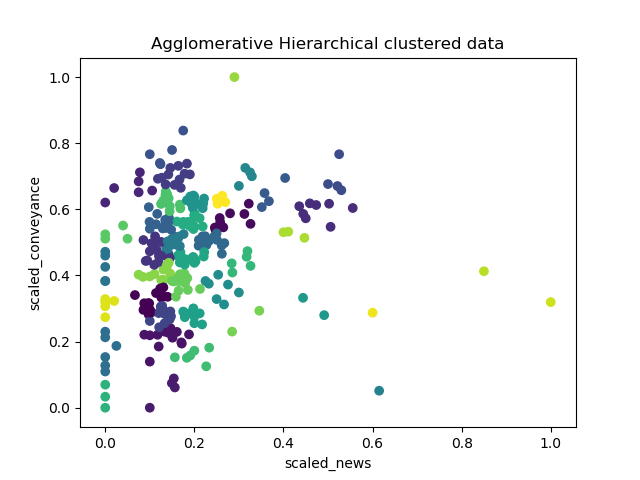

40


Text(0.5,1,'Agglomerative Hierarchical clustered data')

In [42]:
from sklearn.cluster import AgglomerativeClustering
fig = plt.figure()
X = mpds_filtered[['scaled_news','scaled_conveyance']].values
clustering = AgglomerativeClustering(40).fit(X)
mpds_filtered['agglomerative_Hierarchical_cluster'] = clustering.labels_
ax = fig.add_subplot(111)
labels = clustering.labels_
ax.scatter(X[:, 0], X[:, 1],
               c=labels.astype(np.float))
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('Agglomerative Hierarchical clustered data')


In [43]:
mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")
for cluster in mpds_filtered.agglomerative_Hierarchical_cluster.unique():
        current_frame = mpds_filtered[mpds_filtered['agglomerative_Hierarchical_cluster']==cluster]
        #pandas sorts by highest frequency first so we can take the first index to get the majority class
        mpds_filtered.loc[mpds_filtered.agglomerative_Hierarchical_cluster==cluster, 'majority_class'] =current_frame['MPDS_priority'].value_counts().index[0]

<IPython.core.display.Javascript object>


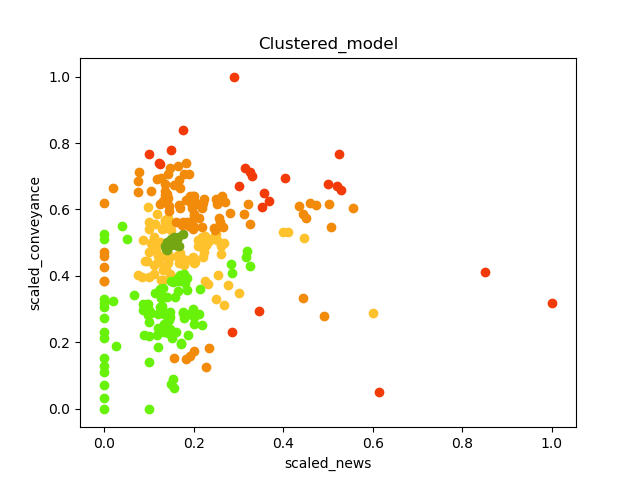

Text(0.5,1,'Clustered_model')

In [44]:
color_dict = {'AMBER1': '#F28B09', 'AMBER2': '#FEC22D','GREEN3':'#69F209', 'RED':'#F23B09', 'GREEN2':'#73A612'}
fig = plt.figure()
ax = fig.add_subplot(111)

for mpds in mpds_filtered['majority_class'].unique():
    current_plot_frame = mpds_filtered[mpds_filtered['majority_class']==mpds]
    coordinates = current_plot_frame[['scaled_news','scaled_conveyance',]]
    ax.scatter(coordinates.iloc[:,0],coordinates.iloc[:,1],c=color_dict[mpds])

ax.set_xlabel('scaled_news')
ax.set_ylabel('scaled_conveyance')
ax.set_title('Clustered_model')

In [45]:
X = mpds_filtered[['scaled_news','scaled_conveyance','died_in_hospital_rate','admitted_rate']].values
clust = AgglomerativeClustering(40).fit(X)
clust.fit(X)
labels = clust.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")

mpds_filtered = mpds_filtered.assign(majority_class = "To Be filled")
for cluster in mpds_filtered.agglomerative_Hierarchical_cluster.unique():
        current_frame = mpds_filtered[mpds_filtered['agglomerative_Hierarchical_cluster']==cluster]
        #pandas sorts by highest frequency first so we can take the first index to get the majority class
        mpds_filtered.loc[mpds_filtered.agglomerative_Hierarchical_cluster==cluster, 'majority_class'] =current_frame['MPDS_priority'].value_counts().index[0]

40


In [46]:
mpds_filtered[((mpds_filtered.MPDS_priority=="RED") & (mpds_filtered.majority_class!="RED"))]

MPDS_priority                                 Description dispatch_code  \
27            RED                Underwater (DOMESTIC rescue)         14E02   
29            RED                                 Unconscious         14D01   
62            RED                       INEFFECTIVE BREATHING         09D01   
67            RED                                    Override         31E00   
73            RED       Not breathing (after Key Questioning)         12D01   
77            RED                                 Suffocation         09E05   
108           RED       Baby born (complications with mother)         24D07   
115           RED                                 Unconscious         30D02   
138           RED                                 Unconscious         07D03   
141           RED                                 Unconscious         17D03   
148           RED                                 Unconscious         03D02   
166           RED                                      Arrest         03D01   
178           RED                         UNCERTAIN BREATHING         09E02   
181           RED         DIFFICULTY SPEAKING BETWEEN BREATHS         02D02   
201           RED                                      Arrest         29D06   
207           RED                                 Unconscious         08D02   
214           RED                                      Arrest         08D01   
218           RED                        Not breathing at all         09E01   
249           RED                               Strangulation         09E04   
271           RED                     HIGH RISK complications         24D05   
272           RED                            Head visible/out         24D02   
286           RED  Unconscious – AGONAL/INEFFECTIVE BREATHING         31D01   
288           RED                                    Override         23D00   

            NatureOfIncidentDescription  died_in_hospital_rate  admitted_rate  \
27          DROWNING(NEAR)/DIVING/SCUBA               0.000000       0.200000   
29          DROWNING(NEAR)/DIVING/SCUBA               0.181818       0.212121   
62     CARDIAC/RESPIRATORY ARREST/DEATH               0.302616       0.207527   
67           UNCONSCIOUS/FAINTING(NEAR)               0.000000       0.000000   
73                  CONVULSIONS/FITTING               0.215384       0.229508   
77     CARDIAC/RESPIRATORY ARREST/DEATH               0.000000       0.000000   
108    PREGNANCY/CHILDBIRTH/MISCARRIAGE               0.000000       0.000000   
115        TRAUMATIC INJURIES, SPECIFIC               0.017857       0.239061   
138             BURNS(SCALDS)/EXPLOSION               0.000000       0.333333   
141                               FALLS               0.057781       0.329699   
148                ANIMAL BITES/ATTACKS               0.000000       0.227272   
166                ANIMAL BITES/ATTACKS               0.000000       0.000000   
178    CARDIAC/RESPIRATORY ARREST/DEATH               0.238578       0.288834   
181  ALLERGIES(REACTIONS)/ENVENOMATIONS               0.002898       0.205025   
201    TRAFFIC/TRANSPORTATION ACCIDENTS               0.071428       0.136363   
207  CARBON MONOXIDE/INHALATION/HAZCHEM               0.062500       0.176470   
214  CARBON MONOXIDE/INHALATION/HAZCHEM               0.200000       0.045454   
218    CARDIAC/RESPIRATORY ARREST/DEATH               0.510966       0.079899   
249    CARDIAC/RESPIRATORY ARREST/DEATH               0.300000       0.222222   
271    PREGNANCY/CHILDBIRTH/MISCARRIAGE               0.000000       0.063607   
272    PREGNANCY/CHILDBIRTH/MISCARRIAGE               0.000000       0.000000   
286          UNCONSCIOUS/FAINTING(NEAR)               0.200854       0.263565   
288      OVERDOSE/POISONING (INGESTION)               0.250000       0.333333   

     frequency  scaled_news  scaled_conveyance  cluster_number_kmeans  \
27          10     0.000000           0.383334                      0   
29          33  